# Сравнение подходов к ранжированию: Pointwise, Pairwise, Listwise

В данном проекте мы проводим сравнительный анализ трех подходов к обучению ранжированию (Learning to Rank) на примере датасета новостей:
1.  **Pointwise** (Поточечный): Бинарная классификация (LightGBM).
2.  **Pairwise** (Попарный): Линейная модель RankNet (SGD Classifier на разностях).
3.  **Listwise** (Списочный): LambdaMART (LightGBM).

## 0. Настройка окружения и импорты

In [3]:
from pathlib import Path
import gc
import time
import warnings
from dataclasses import dataclass

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, vstack
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Настройка стиля графиков
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "font.family": "sans-serif", # Убедитесь, что шрифт поддерживает кириллицу, обычно sans-serif ок
})

DATA_DIR = Path(".")
NEWS_PATH = DATA_DIR / "news.tsv"
BEHAVIORS_PATH = DATA_DIR / "behaviors.tsv"

## 1. Загрузка и первичная подготовка данных
Загружаем данные новостей и взаимодействий пользователей. Преобразуем строковые логи показов в удобный для анализа формат.

In [4]:
NEWS_COLUMNS = [
    "news_id",
    "category",
    "subcategory",
    "title",
    "abstract",
    "url",
    "title_entities",
    "abstract_entities",
]
BEHAVIOR_COLUMNS = ["impression_id", "user", "time", "history", "impressions"]

print("Загрузка данных...")
news = pd.read_csv(NEWS_PATH, sep="\t", header=None, names=NEWS_COLUMNS)
beh = pd.read_csv(BEHAVIORS_PATH, sep="\t", header=None, names=BEHAVIOR_COLUMNS)

# Раскрываем список показов на отдельные строки
print("Обработка взаимодействий...")
impr = (
    beh["impressions"]
    .str.split(" ", expand=True)
    .stack()
    .reset_index(level=1, drop=True)
    .to_frame("item_label")
)
impr["item"] = impr["item_label"].str.split("-").str[0]
impr["label"] = impr["item_label"].str.split("-").str[1].astype(int)

beh_expanded = beh.drop(columns=["impressions"]).join(impr)

# Индексация новостей и связь с взаимодействиями
news["news_idx"] = np.arange(len(news))
news_id_to_idx = news.set_index("news_id")["news_idx"]
beh_expanded["item_idx"] = beh_expanded["item"].map(news_id_to_idx)
beh_expanded = beh_expanded.dropna(subset=["item_idx"]).copy()
beh_expanded["item_idx"] = beh_expanded["item_idx"].astype(int)

print(f"Новости: {len(news):,} строк | Взаимодействия: {len(beh_expanded):,} строк")

Загрузка данных...
Обработка взаимодействий...
Новости: 51,282 строк | Взаимодействия: 5,843,444 строк


### 1.1 Временное разбиение train/val/test


In [5]:
beh_expanded["time"] = pd.to_datetime(beh_expanded["time"])

beh_expanded = beh_expanded.sort_values("time")
ts = beh_expanded["time"].values

train_end = ts[int(0.70 * len(ts))]
val_end = ts[int(0.85 * len(ts))]

train = beh_expanded[beh_expanded["time"] <= train_end].copy()
val   = beh_expanded[(beh_expanded["time"] > train_end) & (beh_expanded["time"] <= val_end)].copy()
test  = beh_expanded[beh_expanded["time"] > val_end].copy()

print(f"Splits: train={len(train)}, val={len(val)}, test={len(test)}")

Splits: train=4090523, val=876520, test=876401


## 2. Разведочный анализ


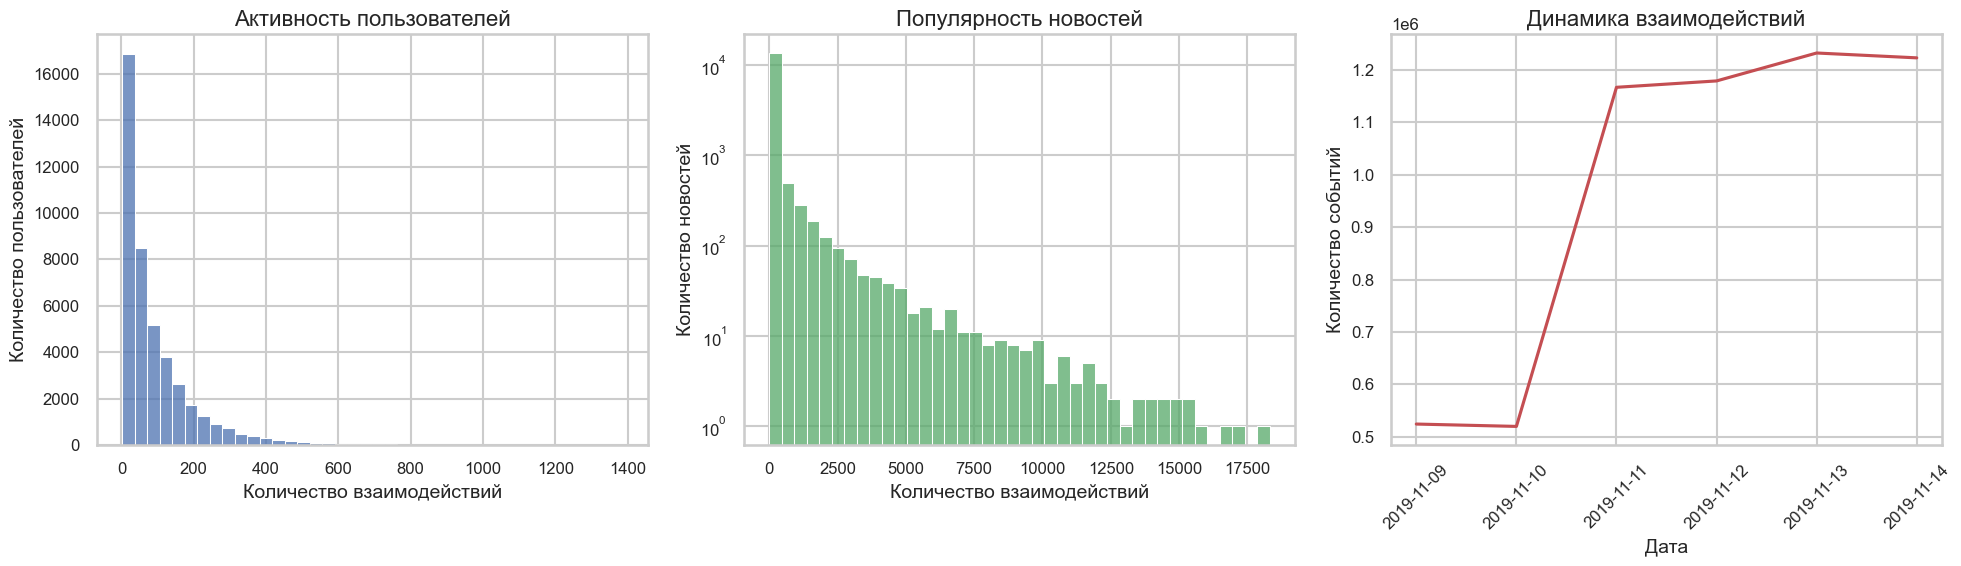

In [6]:
user_activity = train.groupby("user")["label"].count()
item_activity = train.groupby("item")["label"].count()
daily_interactions = beh_expanded.set_index("time")["label"].resample("D").count()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(user_activity, bins=40, ax=axes[0], color="#4C72B0")
axes[0].set_title("Активность пользователей")
axes[0].set_xlabel("Количество взаимодействий")
axes[0].set_ylabel("Количество пользователей")

sns.histplot(item_activity, bins=40, ax=axes[1], color="#55A868")
axes[1].set_title("Популярность новостей")
axes[1].set_xlabel("Количество взаимодействий")
axes[1].set_ylabel("Количество новостей")
axes[1].set_yscale("log")

sns.lineplot(x=daily_interactions.index, y=daily_interactions.values, ax=axes[2], color="#C44E52")
axes[2].set_title("Динамика взаимодействий")
axes[2].set_xlabel("Дата")
axes[2].set_ylabel("Количество событий")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 3. Построение признаков


In [7]:
# TF-IDF по заголовкам
tfidf = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf.fit_transform(news["title"].fillna(""))

# Категории
cat_enc = LabelEncoder()
cat = cat_enc.fit_transform(news["category"].fillna(""))

# Дополнительные признаки
news["title_len"] = news["title"].fillna("").str.len()
news["pub_hours"] = (
    pd.to_datetime(news["url"].str.extract(r"(\d{4}-\d{2}-\d{2})")[0])
    - pd.Timestamp("2020-01-01")
).dt.days.fillna(0)

# Популярность (Global Popularity)
pop = train.groupby("item")["label"].mean()
global_pop = pop.mean() if not pop.empty else 0
news["pop"] = news["news_id"].map(pop).fillna(global_pop)

X_dense = pd.DataFrame({
    "cat": cat,
    "title_len": news["title_len"],
    "pub_hours": news["pub_hours"],
    "pop": news["pop"],
})

sc = MinMaxScaler()
X_dense_scaled = sc.fit_transform(X_dense)

# Итоговая матрица признаков на уровне news_idx
X = hstack([tfidf_features, csr_matrix(X_dense_scaled)]).tocsr()
n_items, n_features = X.shape
print(f"Матрица признаков: {n_items} новостей x {n_features} признаков")

Матрица признаков: 51282 новостей x 5004 признаков


## 4. Модели ранжирования


### 4.1 Pointwise (LightGBM: binary objective)

In [8]:
def make_lgb_dataset(df):
    df_sorted = df.sort_values(["impression_id", "time"]).copy()
    X_local = X[df_sorted["item_idx"].values]
    y_local = df_sorted["label"].values
    groups = df_sorted.groupby("impression_id").size().values
    return lgb.Dataset(X_local, label=y_local, group=groups, free_raw_data=False)

print("Подготовка датасетов для Pointwise/Listwise...")
train_lgb = make_lgb_dataset(train)
val_lgb   = make_lgb_dataset(val)
print(f"Групп в Train: {len(train_lgb.get_group())}, Групп в Val: {len(val_lgb.get_group())}")

Подготовка датасетов для Pointwise/Listwise...
Групп в Train: 112662, Групп в Val: 22067


### 4.2 Pairwise (Linear RankNet)


In [9]:
# 4.2 Pairwise: Linear RankNet (SGD on differences)
# Обучаем линейную модель классификации на разностях признаков: (X_pos - X_neg).

def make_pairwise_dataset(df, max_pairs=200000):
    groups = df.groupby("impression_id")
    X_pairs_list = []
    y_pairs_list = []
    pair_count = 0

    for _, g in groups:
        pos_items = g[g["label"] == 1]["item_idx"].values
        neg_items = g[g["label"] == 0]["item_idx"].values
        if len(pos_items) == 0 or len(neg_items) == 0:
            continue

        stop = False
        for p_idx in pos_items:
            for n_idx in neg_items:
                diff = X[p_idx] - X[n_idx]
                X_pairs_list.append(diff)
                y_pairs_list.append(1)
                X_pairs_list.append(-diff)
                y_pairs_list.append(0)
                pair_count += 2
                if pair_count >= max_pairs:
                    stop = True
                    break
            if stop:
                break
        if stop:
            break

    return vstack(X_pairs_list), np.array(y_pairs_list)

print("Генерация пар для Pairwise подхода (это может занять время)...")
_t0 = time.perf_counter()
X_pair_train, y_pair_train = make_pairwise_dataset(train)
pairwise_dataset_build_s = time.perf_counter() - _t0
print(f"Размер Pairwise датасета: {X_pair_train.shape}")
print(f"Время генерации пар: {pairwise_dataset_build_s:.3f} сек")

Генерация пар для Pairwise подхода (это может занять время)...
Размер Pairwise датасета: (200000, 5004)
Время генерации пар: 37.719 сек


In [ ]:
training_times = {}
training_stats = {}

inference_times = {}
inference_stats = {}

execution_times = {}
execution_stats = {}

# --- Вспомогательные функции ---

def evaluate(model, df):
    """Оценка модели: предсказание + расчет метрик (NDCG, MRR, HitRate)."""
    global X

    df = df.sort_values(["impression_id"])
    groups = df.groupby("impression_id")

    ndcg5, ndcg10, mrr, acc = [], [], [], []

    for _, g in groups:
        if len(g) < 2:
            continue

        X_local = X[g["item_idx"].values]
        preds = model.predict(X_local)
        y = g["label"].values.reshape(1, -1)
        preds = np.asarray(preds).reshape(1, -1)

        ndcg5.append(ndcg_score(y, preds, k=5))
        ndcg10.append(ndcg_score(y, preds, k=10))

        order = np.argsort(-preds.ravel())

        # Hit@1
        acc.append(1 if y.ravel()[order][0] == 1 else 0)

        # MRR
        hits = np.where(y.ravel()[order] == 1)[0]
        mrr.append(1.0 / (hits[0] + 1) if len(hits) > 0 else 0.0)

    if not ndcg5:
        return np.nan, np.nan, np.nan, np.nan

    return float(np.mean(ndcg5)), float(np.mean(ndcg10)), float(np.mean(mrr)), float(np.mean(acc))


class ModelWrapper:
    """Обертка для sklearn классификаторов, чтобы возвращать вероятность класса 1."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]


@dataclass
class TimingStats:
    mean_s: float
    std_s: float
    n: int
    meta: dict


def _mean_std(values):
    values = np.asarray(values, dtype=float)
    if values.size == 0:
        return np.nan, np.nan
    mean = float(values.mean())
    std = float(values.std(ddof=1) if values.size > 1 else 0.0)
    return mean, std


def bench_predict(predict_fn, X_batch, *, warmup=10, repeat=50):
    for _ in range(int(warmup)):
        _ = predict_fn(X_batch)

    t = np.empty(int(repeat), dtype=np.float64)
    for i in range(int(repeat)):
        t0 = time.perf_counter()
        _ = predict_fn(X_batch)
        t[i] = time.perf_counter() - t0

    mean, std = _mean_std(t)
    return TimingStats(mean_s=mean, std_s=std, n=int(repeat), meta={"warmup": int(warmup)})


def bench_evaluate(model, df, *, warmup=1, repeat=3):
    for _ in range(int(warmup)):
        _ = evaluate(model, df)

    t = np.empty(int(repeat), dtype=np.float64)
    for i in range(int(repeat)):
        t0 = time.perf_counter()
        _ = evaluate(model, df)
        t[i] = time.perf_counter() - t0

    mean, std = _mean_std(t)
    return TimingStats(mean_s=mean, std_s=std, n=int(repeat), meta={"warmup": int(warmup)})



def train_and_eval_all(seeds=[42, 43]):
    results = {
        "Поточечный (LGBM)": {"ndcg5": [], "ndcg10": [], "mrr": [], "accuracy": []},
        "Попарный (Linear)": {"ndcg5": [], "ndcg10": [], "mrr": [], "accuracy": []},
        "Списочный (LambdaMART)": {"ndcg5": [], "ndcg10": [], "mrr": [], "accuracy": []},
    }

    last_models = {}

    fit_times_log = {
        "Поточечный (LGBM)": [],
        "Попарный (Linear)": [],
        "Списочный (LambdaMART)": [],
    }

    exec_times_log = {
        "Поточечный (LGBM)": [],
        "Попарный (Linear)": [],
        "Списочный (LambdaMART)": [],
    }

    pair_build_s = float(globals().get("pairwise_dataset_build_s", 0.0) or 0.0)
    if pair_build_s > 0:
        print(f"Время генерации пар (добавляется к обучению Попарного метода): {pair_build_s:.3f}с")

    print(f"Запуск оценки на {len(seeds)} случайных зернах (seeds)...")

    for seed in seeds:
        print(f"--- Seed {seed} ---")

        # 1. Pointwise LGBM
        print("Обучение Поточечного (LGBM)...")
        start_time = time.perf_counter()
        params_pt = {
            "objective": "binary",
            "metric": "auc",
            "learning_rate": 0.05,
            "num_leaves": 64,
            "seed": seed,
            "verbose": -1,
        }
        lgb_pt = lgb.train(
            params_pt,
            train_lgb,
            num_boost_round=150,
            valid_sets=[val_lgb],
            callbacks=[lgb.early_stopping(20, verbose=False)],
        )
        duration = time.perf_counter() - start_time
        fit_times_log["Поточечный (LGBM)"].append(duration)
        print(f"  -> Готово за {duration:.2f}с. Лучшая итерация: {lgb_pt.best_iteration}")

        t0 = time.perf_counter()
        m_pt = evaluate(lgb_pt, test)
        exec_times_log["Поточечный (LGBM)"].append(time.perf_counter() - t0)

        results["Поточечный (LGBM)"]["ndcg5"].append(m_pt[0])
        results["Поточечный (LGBM)"]["ndcg10"].append(m_pt[1])
        results["Поточечный (LGBM)"]["mrr"].append(m_pt[2])
        results["Поточечный (LGBM)"]["accuracy"].append(m_pt[3])
        last_models["Поточечный (LGBM)"] = lgb_pt

        # 2. Pairwise Linear (SGD)
        print("Обучение Попарного (Linear)...")
        start_time = time.perf_counter()
        pw_model = SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-4, max_iter=100, random_state=seed)
        pw_model.fit(X_pair_train, y_pair_train)
        duration = time.perf_counter() - start_time
        fit_times_log["Попарный (Linear)"].append(duration)
        print(f"  -> Готово за {duration:.2f}с.")

        pw_wrapper = ModelWrapper(pw_model)

        t0 = time.perf_counter()
        m_pw = evaluate(pw_wrapper, test)
        exec_times_log["Попарный (Linear)"].append(time.perf_counter() - t0)

        results["Попарный (Linear)"]["ndcg5"].append(m_pw[0])
        results["Попарный (Linear)"]["ndcg10"].append(m_pw[1])
        results["Попарный (Linear)"]["mrr"].append(m_pw[2])
        results["Попарный (Linear)"]["accuracy"].append(m_pw[3])
        last_models["Попарный (Linear)"] = pw_wrapper

        # 3. Listwise LambdaMART
        print("Обучение Списочного (LambdaMART)...")
        start_time = time.perf_counter()
        params_lm = {
            "objective": "lambdarank",
            "metric": "ndcg",
            "ndcg_eval_at": [5, 10],
            "learning_rate": 0.05,
            "num_leaves": 128,
            "seed": seed,
            "verbose": -1,
        }
        lgb_lm = lgb.train(
            params_lm,
            train_lgb,
            num_boost_round=150,
            valid_sets=[val_lgb],
            callbacks=[lgb.early_stopping(20, verbose=False)],
        )
        duration = time.perf_counter() - start_time
        fit_times_log["Списочный (LambdaMART)"].append(duration)
        print(f"  -> Готово за {duration:.2f}с. Лучшая итерация: {lgb_lm.best_iteration}")

        t0 = time.perf_counter()
        m_lm = evaluate(lgb_lm, test)
        exec_times_log["Списочный (LambdaMART)"].append(time.perf_counter() - t0)

        results["Списочный (LambdaMART)"]["ndcg5"].append(m_lm[0])
        results["Списочный (LambdaMART)"]["ndcg10"].append(m_lm[1])
        results["Списочный (LambdaMART)"]["mrr"].append(m_lm[2])
        results["Списочный (LambdaMART)"]["accuracy"].append(m_lm[3])
        last_models["Списочный (LambdaMART)"] = lgb_lm

    for model_name, times in fit_times_log.items():
        mean, std = _mean_std(times)
        meta = {"seeds": list(seeds)}

        if model_name == "Попарный (Linear)" and pair_build_s > 0:
            mean = float(mean + pair_build_s)
            meta["pair_generation_s"] = pair_build_s

        training_times[model_name] = mean
        training_stats[model_name] = TimingStats(mean_s=mean, std_s=std, n=len(times), meta=meta)
        print(f"Время обучения {model_name}: {mean:.4f}с ± {std:.4f}с")

    for model_name, times in exec_times_log.items():
        mean, std = _mean_std(times)
        execution_times[model_name] = mean
        execution_stats[model_name] = TimingStats(
            mean_s=mean, std_s=std, n=len(times), meta={"seeds": list(seeds)}
        )
        print(f"Время выполнения (predict+metrics) {model_name}: {mean:.4f}с ± {std:.4f}с")

    return results, last_models


final_results, last_models = train_and_eval_all(seeds=[42, 43, 44, 45, 46])

lgb_model = last_models["Поточечный (LGBM)"]
lambda_model = last_models["Списочный (LambdaMART)"]
pairwise_wrapper = last_models["Попарный (Linear)"]

rows = []
for model, metrics in final_results.items():
    row = {"Модель": model}
    for m_name, values in metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        row[m_name] = f"{mean:.4f} ± {std:.4f}"
    rows.append(row)

df_stats = pd.DataFrame(rows)
print("\n=== Итоговые метрики ===")
display(df_stats)

ttest_res = ttest_ind(
    final_results["Списочный (LambdaMART)"]["ndcg10"],
    final_results["Поточечный (LGBM)"]["ndcg10"],
)
print(f"\nT-Test Списочный vs Поточечный (NDCG@10): p-value = {ttest_res.pvalue:.4f}")

print("\nЗамер скорости чистого предсказания (Batch Inference)...")

unique_items = np.unique(test["item_idx"].values)
BATCH_N = int(min(20000, len(unique_items)))
rng = np.random.default_rng(42)
batch_items = rng.choice(unique_items, size=BATCH_N, replace=False)
X_test_batch = X[batch_items]

gc.collect()
inference_stats["Поточечный (LGBM)"] = bench_predict(
    lambda xb: lgb_model.predict(xb, num_iteration=getattr(lgb_model, "best_iteration", None)),
    X_test_batch,
    warmup=10,
    repeat=50,
)
inference_times["Поточечный (LGBM)"] = inference_stats["Поточечный (LGBM)"].mean_s

gc.collect()
inference_stats["Списочный (LambdaMART)"] = bench_predict(
    lambda xb: lambda_model.predict(xb, num_iteration=getattr(lambda_model, "best_iteration", None)),
    X_test_batch,
    warmup=10,
    repeat=50,
)
inference_times["Списочный (LambdaMART)"] = inference_stats["Списочный (LambdaMART)"].mean_s

gc.collect()
inference_stats["Попарный (Linear)"] = bench_predict(
    lambda xb: pairwise_wrapper.predict(xb),
    X_test_batch,
    warmup=10,
    repeat=50,
)
inference_times["Попарный (Linear)"] = inference_stats["Попарный (Linear)"].mean_s

for model_name in ["Поточечный (LGBM)", "Списочный (LambdaMART)", "Попарный (Linear)"]:
    s = inference_stats[model_name]
    print(f"{model_name:>22}: {s.mean_s:.6f}с (пачка {BATCH_N} элементов)")

Время генерации пар (добавляется к обучению Попарного метода): 37.719с
Запуск оценки на 5 случайных зернах (seeds)...
--- Seed 42 ---
Обучение Поточечного (LGBM)...
  -> Готово за 98.98с. Лучшая итерация: 3
Обучение Попарного (Linear)...
  -> Готово за 0.72с.
Обучение Списочного (LambdaMART)...
  -> Готово за 90.04с. Лучшая итерация: 2
--- Seed 43 ---
Обучение Поточечного (LGBM)...
  -> Готово за 91.85с. Лучшая итерация: 3
Обучение Попарного (Linear)...
  -> Готово за 0.65с.
Обучение Списочного (LambdaMART)...
  -> Готово за 86.04с. Лучшая итерация: 2
--- Seed 44 ---
Обучение Поточечного (LGBM)...
  -> Готово за 98.32с. Лучшая итерация: 3
Обучение Попарного (Linear)...
  -> Готово за 0.67с.
Обучение Списочного (LambdaMART)...
  -> Готово за 88.89с. Лучшая итерация: 2
--- Seed 45 ---
Обучение Поточечного (LGBM)...
  -> Готово за 75.81с. Лучшая итерация: 3
Обучение Попарного (Linear)...
  -> Готово за 0.65с.
Обучение Списочного (LambdaMART)...
  -> Готово за 94.67с. Лучшая итерация: 2
--

,Модель,ndcg5,ndcg10,mrr,accuracy
0,Поточечный (LGBM),0.2294 ± 0.0000,0.2893 ± 0.0000,0.2563 ± 0.0000,0.1187 ± 0.0000
1,Попарный (Linear),0.2336 ± 0.0023,0.2974 ± 0.0020,0.2583 ± 0.0025,0.1129 ± 0.0026
2,Списочный (LambdaMART),0.2405 ± 0.0000,0.3000 ± 0.0000,0.2671 ± 0.0000,0.1280 ± 0.0000



T-Test Списочный vs Поточечный (NDCG@10): p-value = 0.0000

Замер скорости чистого предсказания (Batch Inference)...


d:\py\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


     Поточечный (LGBM): 0.001097с (пачка 4955 элементов)
Списочный (LambdaMART): 0.000661с (пачка 4955 элементов)
     Попарный (Linear): 0.000679с (пачка 4955 элементов)


## 6. Визуализация результатов


C:\Users\paull\AppData\Local\Temp\ipykernel_18236\162123246.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Модель", y="NDCG@5", data=df_plot, palette="viridis")
C:\Users\paull\AppData\Local\Temp\ipykernel_18236\162123246.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x="Модель", y="NDCG@10", data=df_plot, palette="viridis")
C:\Users\paull\AppData\Local\Temp\ipykernel_18236\162123246.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x="Модель", y="MRR", data=df_plot, palette="viridis")
C:\

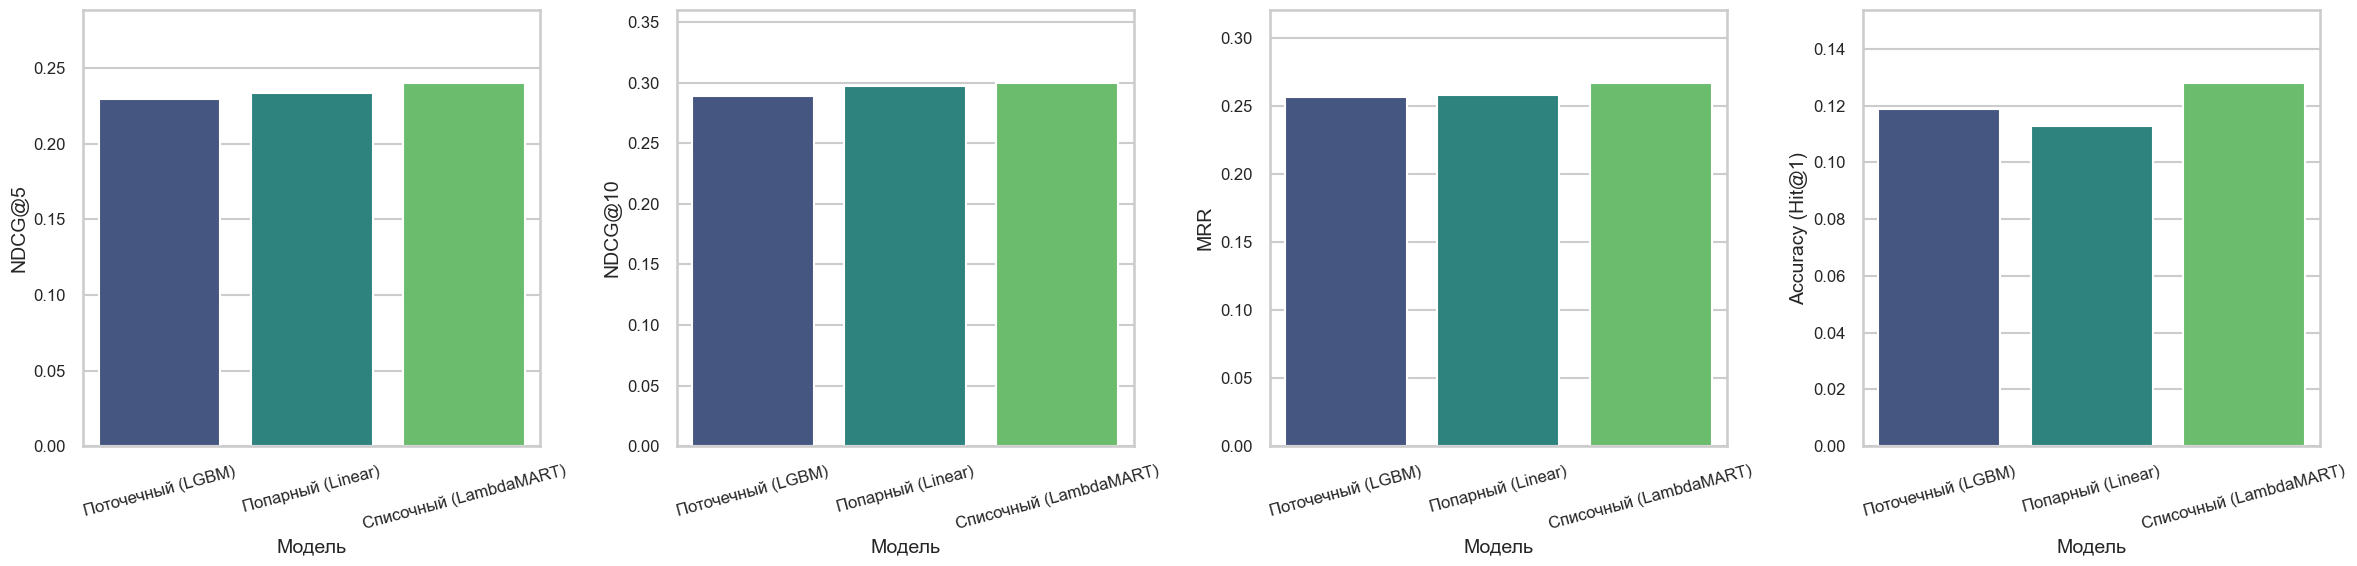

In [ ]:
models = list(final_results.keys())
ndcg5 = [np.mean(final_results[m]["ndcg5"]) for m in models]
ndcg10 = [np.mean(final_results[m]["ndcg10"]) for m in models]
mrr = [np.mean(final_results[m]["mrr"]) for m in models]
acc = [np.mean(final_results[m]["accuracy"]) for m in models]

df_plot = pd.DataFrame({
    "Модель": models,
    "NDCG@5": ndcg5,
    "NDCG@10": ndcg10,
    "MRR": mrr,
    "Accuracy (Hit@1)": acc
})

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
sns.barplot(ax=axes[0], x="Модель", y="NDCG@5", data=df_plot, palette="viridis")
axes[0].tick_params(axis='x', rotation=15)
axes[0].set_ylim(0, max(ndcg5)*1.2)

sns.barplot(ax=axes[1], x="Модель", y="NDCG@10", data=df_plot, palette="viridis")
axes[1].tick_params(axis='x', rotation=15)
axes[1].set_ylim(0, max(ndcg10)*1.2)

sns.barplot(ax=axes[2], x="Модель", y="MRR", data=df_plot, palette="viridis")
axes[2].tick_params(axis='x', rotation=15)
axes[2].set_ylim(0, max(mrr)*1.2)

sns.barplot(ax=axes[3], x="Модель", y="Accuracy (Hit@1)", data=df_plot, palette="viridis")
axes[3].tick_params(axis='x', rotation=15)
axes[3].set_ylim(0, max(acc)*1.2)

plt.tight_layout()
plt.show()

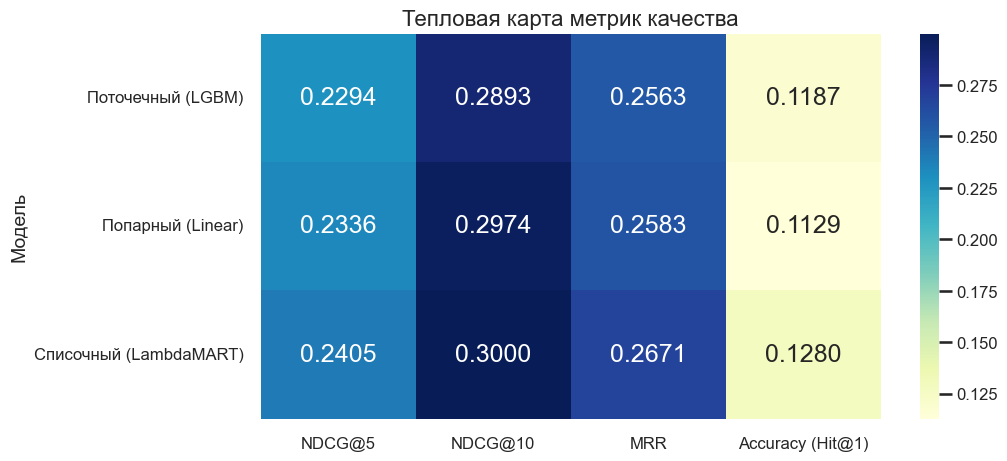

In [12]:
metric_matrix = df_plot.set_index("Модель")[["NDCG@5", "NDCG@10", "MRR", "Accuracy (Hit@1)"]]

plt.figure(figsize=(10, 5))
sns.heatmap(metric_matrix, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Тепловая карта метрик качества")
plt.ylabel("Модель")
plt.show()

## 7. Сравнение времени обучения и выполнения

В разделе ниже «выполнение» измеряется как полный прогон `predict + расчёт метрик` на тестовой выборке (NDCG@5/10, MRR, Hit@1). Для Pairwise во «время обучения» дополнительно включено время формирования пар.

,Модель,Обучение (сек),Выполнение (сек)
0,Попарный (Linear),38.359449,43.661078
1,Поточечный (LGBM),89.858910,41.547111
2,Списочный (LambdaMART),89.037384,41.302747


C:\Users\paull\AppData\Local\Temp\ipykernel_18236\3298542249.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=timing_df, x="Модель", y="Обучение (сек)", palette="Blues_d")
C:\Users\paull\AppData\Local\Temp\ipykernel_18236\3298542249.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=timing_df, x="Модель", y="Выполнение (сек)", palette="Greens_d")


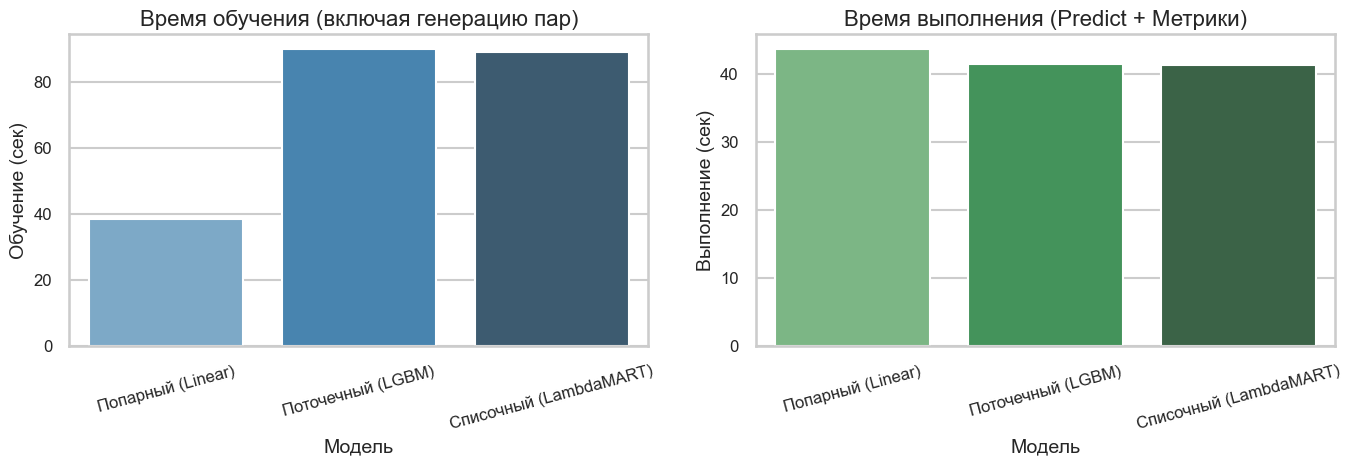

In [13]:
def _safe_stat(stats_dict, name, field, default=np.nan):
    try:
        return getattr(stats_dict.get(name, None), field)
    except Exception:
        return default

timing_records = []
all_models = sorted(
    set(
        list(training_times.keys())
        + list(globals().get("execution_times", {}).keys())
        + list(globals().get("inference_times", {}).keys())
    )
)

for model in all_models:
    tr_mean = training_times.get(model, np.nan)
    exec_mean = globals().get("execution_times", {}).get(model, np.nan)
    
    timing_records.append({
        "Модель": model,
        "Обучение (сек)": tr_mean,
        "Выполнение (сек)": exec_mean,
    })

timing_df = pd.DataFrame(timing_records)

if timing_df.empty:
    print("Данные не собраны. Сначала запустите ячейки с обучением.")
else:
    display(timing_df)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(ax=axes[0], data=timing_df, x="Модель", y="Обучение (сек)", palette="Blues_d")
    axes[0].set_title("Время обучения (включая генерацию пар)")
    axes[0].tick_params(axis="x", rotation=15)

    sns.barplot(ax=axes[1], data=timing_df, x="Модель", y="Выполнение (сек)", palette="Greens_d")
    axes[1].set_title("Время выполнения (Predict + Метрики)")
    axes[1].tick_params(axis="x", rotation=15)

    plt.tight_layout()
    plt.show()

## 8. Диагностика: распределения скоров


Построение графиков распределения скоров...


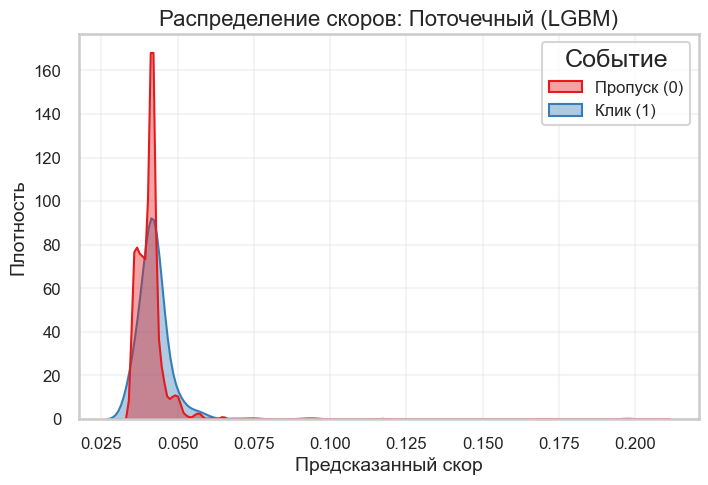

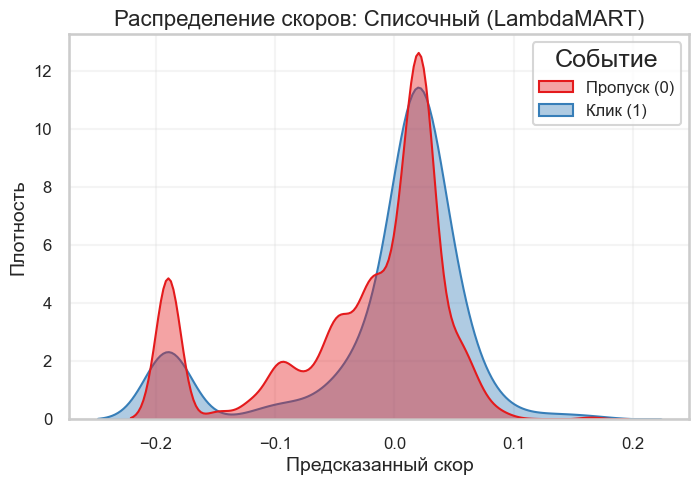

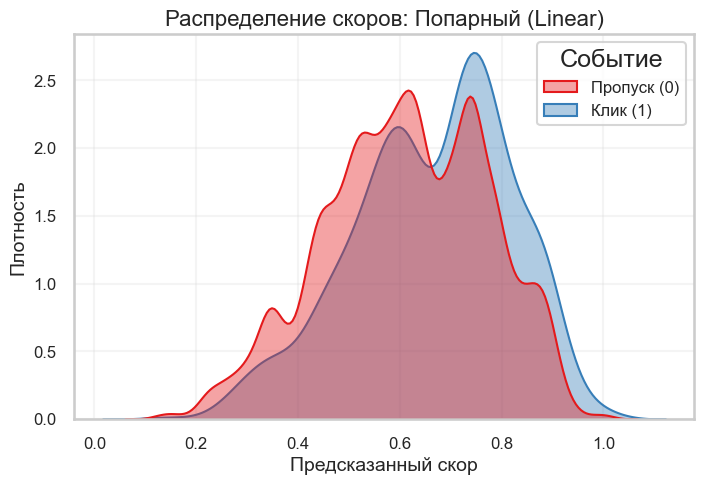

In [18]:
def plot_score_distribution(model, df, model_name, sample_size=20000, ax=None):
    """Визуализация распределения скоров для кликнутых и некликнутых документов."""
    df_local = df.sort_values("time")[["item_idx", "label"]].copy()
    X_local = X[df_local["item_idx"].values]
    preds = model.predict(X_local)
    
    # Используем русское название колонки для корректного отображения в легенде
    df_scores = pd.DataFrame({"score": preds, "Событие": df_local["label"].values})
    
    if len(df_scores) > sample_size:
        df_scores = df_scores.sample(sample_size, random_state=42)
    
    df_scores["Событие"] = df_scores["Событие"].map({1: "Клик (1)", 0: "Пропуск (0)"})

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 5))
    
    sns.kdeplot(
        data=df_scores,
        x="score",
        hue="Событие",
        fill=True,
        common_norm=False,
        alpha=0.4,
        ax=ax,
        palette="Set1"
    )
    ax.set_title(f"Распределение скоров: {model_name}")
    ax.set_xlabel("Предсказанный скор")
    ax.set_ylabel("Плотность")
    ax.grid(alpha=0.2)

# Визуализация для каждого метода отдельно
print("Построение графиков распределения скоров...")

plot_score_distribution(lgb_model, val, "Поточечный (LGBM)")
plt.show()

plot_score_distribution(lambda_model, val, "Списочный (LambdaMART)")
plt.show()

plot_score_distribution(pairwise_wrapper, val, "Попарный (Linear)")
plt.show()

### Интерпретация графиков распределения скоров

1.  **Поточечный (LGBM)**: Наблюдается эффект "схлопывания" (score collapsing). Предсказания концентрируются в очень узком диапазоне, соответствующем средней вероятности клика (CTR). Различие между позитивными и негативными классами минимально, что затрудняет ранжирование.
2.  **Списочный (LambdaMART)**: Скоры имеют более широкое распределение (логиты). Видно явное смещение распределения "Кликов" вправо относительно "Пропусков", что обеспечивает хорошее качество ранжирования.
3.  **Попарный (Linear RankNet)**: Наилучшее визуальное разделение классов. Линейная модель жертвует калибровкой вероятностей ради правильного порядка, растаскивая классы по разным концам шкалы скоров.

Расчет кривых метрик (NDCG & HitRate) для разных k...


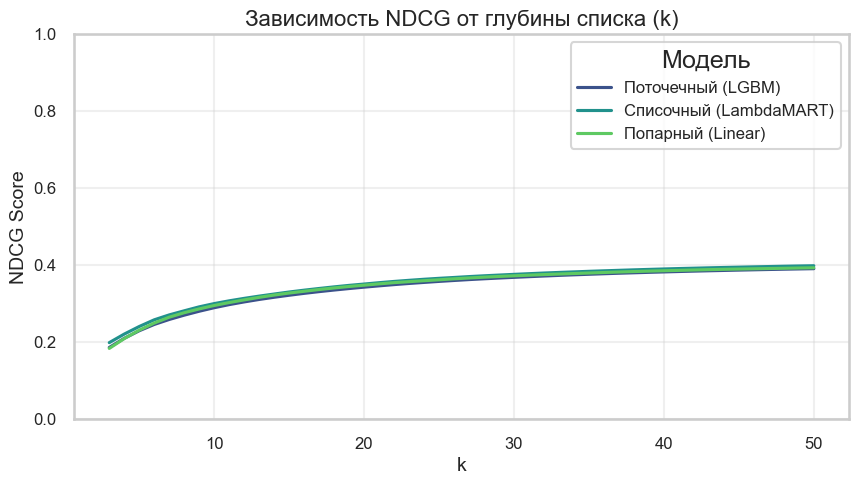

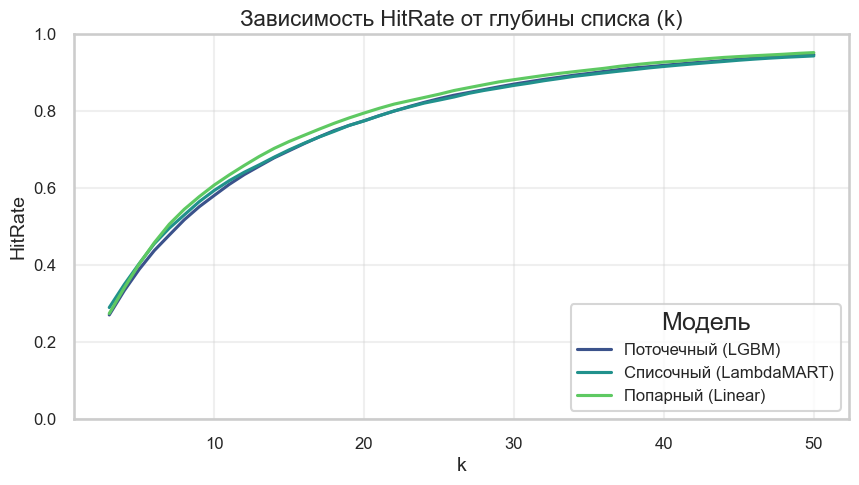

In [15]:
def metrics_by_k(model, df, model_name, ks):
    """Расчет средних NDCG@k и HitRate@k для разных k."""
    groups = df.groupby("impression_id")
    rows = []
    for _, g in groups:
        if len(g) < 2:
            continue
        X_local = X[g["item_idx"].values]
        preds = model.predict(X_local)
        y = g["label"].values
        preds_reshaped = np.asarray(preds).reshape(1, -1)
        y_reshaped = np.asarray(y).reshape(1, -1)

        order = np.argsort(-preds)
        y_sorted = y[order]
        cumsum_hits = np.cumsum(y_sorted)

        for k in ks:
            top_k = min(int(k), len(y_sorted))
            ndcg_k = ndcg_score(y_reshaped, preds_reshaped, k=top_k)
            hit_k = 1.0 if cumsum_hits[top_k - 1] > 0 else 0.0
            rows.append({"Модель": model_name, "k": int(k), "NDCG": float(ndcg_k), "HitRate": float(hit_k)})

    if not rows:
        return pd.DataFrame(columns=["Модель", "k", "NDCG", "HitRate"])
    return pd.DataFrame(rows).groupby(["Модель", "k"], as_index=False).mean()


print("Расчет кривых метрик (NDCG & HitRate) для разных k...")
ks = list(range(3, 51))

curve_pointwise = metrics_by_k(lgb_model, test, "Поточечный (LGBM)", ks)
curve_listwise  = metrics_by_k(lambda_model, test, "Списочный (LambdaMART)", ks)
curve_pairwise  = metrics_by_k(pairwise_wrapper, test, "Попарный (Linear)", ks)

curve_df = pd.concat([curve_pointwise, curve_listwise, curve_pairwise], ignore_index=True)

plt.figure(figsize=(10, 5))
sns.lineplot(data=curve_df, x="k", y="NDCG", hue="Модель", palette="viridis")
plt.title("Зависимость NDCG от глубины списка (k)")
plt.ylabel("NDCG Score")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=curve_df, x="k", y="HitRate", hue="Модель", palette="viridis")
plt.title("Зависимость HitRate от глубины списка (k)")
plt.ylabel("HitRate")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()